# Importar librerías

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
pd.set_option('display.float_format', '{:.6f}'.format)

## Verificar estructura de la columnas de "genres"

In [2]:
df = pd.read_csv('movies_metadata.csv')
df['genres'][0]

c:\users\hansr\appdata\local\programs\python\python38\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


"[{'id': 16, 'name': 'Animation'}, {'id': 35, 'name': 'Comedy'}, {'id': 10751, 'name': 'Family'}]"

Tenemos que arreglar los quotations ya que nos puede dar problema después

In [3]:
df['genres'] = df['genres'].str.replace("\'","\"")

In [4]:
df['genres'][0]

'[{"id": 16, "name": "Animation"}, {"id": 35, "name": "Comedy"}, {"id": 10751, "name": "Family"}]'

## Separar el json genres en columnas

In [5]:
import json
json_cols = ['genres']

def new_json(x):
    return json.loads(x)

for x in json_cols:
    df[x] = df[x].apply(new_json)

In [6]:
def new_json2(x):

    ls = []

    for y in range(len(x[0])):

        for k, v in x[0][y].items():
            ls.append(str(k)+ "_" +str(v))
   
    for z in range(len(ls)):

        if ls[z] not in df.columns:
            df[ls[z]] = 0
            df[ls[z]].iloc[x.name] = 1
        else:
            df[ls[z]].iloc[x.name] = 1
    return

for x in json_cols:
    df[[x]].apply(new_json2, axis=1)

In [7]:
df.columns

Index(['adult', 'belongs_to_collection', 'budget', 'genres', 'homepage', 'id',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'video',
       'vote_average', 'vote_count', 'id_16', 'name_Animation', 'id_35',
       'name_Comedy', 'id_10751', 'name_Family', 'id_12', 'name_Adventure',
       'id_14', 'name_Fantasy', 'id_10749', 'name_Romance', 'id_18',
       'name_Drama', 'id_28', 'name_Action', 'id_80', 'name_Crime', 'id_53',
       'name_Thriller', 'id_27', 'name_Horror', 'id_36', 'name_History',
       'id_878', 'name_Science Fiction', 'id_9648', 'name_Mystery', 'id_10752',
       'name_War', 'id_10769', 'name_Foreign', 'id_10402', 'name_Music',
       'id_99', 'name_Documentary', 'id_37', 'name_Western', 'id_10770',
       'name_TV Movie', 'name_Carousel Productions', 'id_11176'

## Hacer merge los df's

In [8]:
linksdf = pd.read_csv('links_small.csv')
linksdf.head()

,movieId,imdbId,tmdbId
0,1,114709,862.000000
1,2,113497,8844.000000
2,3,113228,15602.000000
3,4,114885,31357.000000
4,5,113041,11862.000000


In [9]:
linksdf.dtypes

movieId      int64
imdbId       int64
tmdbId     float64
dtype: object

Cambiamos el formato para lograr trabajar con mismo dtypes

In [10]:
linksdf['tmdbId'] = linksdf['tmdbId'].astype(str)
linksdf['tmdbId'] = linksdf['tmdbId'].str.replace("\.0","")

In [11]:
linksdf['tmdbId'] = linksdf['tmdbId'].astype(object)

In [12]:
new_df = pd.merge(df,linksdf, left_on = 'id', right_on = 'tmdbId')

### Obtener las columnas relevantes para la variable **Y**

In [13]:
ratingsdf = pd.read_csv('ratings_small.csv')
ratingsfiltered = ratingsdf.drop('timestamp', axis = 1)

In [14]:
finaldf = pd.merge(new_df, ratingsfiltered, on = 'movieId')

Reemplazar los NA's con 0 para que corra la función más adelante

In [15]:
finaldf = finaldf.fillna(0)

## Filtramos solo las columnas de género para el set de X

Las columnas que empiezan con *name* son las que se refieren al género

In [16]:
df_x = finaldf.filter(regex=("^name"))
df_x2 = pd.concat([finaldf['movieId'], df_x], axis = 1)
xdata = df_x2.pivot_table(index='movieId',aggfunc='mean')

In [17]:
xdata.shape

(9025, 32)

## Filtramos solo las columnas necesarias para la variable **Y**

In [18]:
yfiltered = finaldf[['userId', 'movieId', 'rating']]
ypivot = yfiltered.pivot_table(index='movieId',columns='userId',values='rating', aggfunc=np.mean)

In [19]:
ypivot.shape

(9025, 671)

### Convertir los dataframes a matrices de numpy

In [20]:
xnp = xdata.to_numpy()
ynp = np.nan_to_num(ypivot.to_numpy()) #Reemplazar los NA's con 0's

### Convertir ambas matrices a floats para que la función pueda procesarlos

In [21]:
xnp = xnp.astype(float)
ynp = ynp.astype(float)

# Funciones para recomendación

In [22]:
def cost(Y, X, T):
    return(((X @ T.T - Y) ** 2) * ((Y != 0) * 1)).sum()


def gradient(Y, X, T):
    R = (Y != 0) * 1
    hip_error = (X @ T.T - Y) * R

    return (
        hip_error @ T,
        hip_error.T @ X,
    )


def adam(
        Y,
        Xo,
        To,
        fun,
        jac,
        alpha=0.001,
        beta1=0.9,
        beta2=0.999,
        epsilon=0.0000001,
        max_iter=1000
):
    xm = np.zeros(Xo.shape)
    tm = np.zeros(To.shape)

    xv = np.zeros(Xo.shape)
    tv = np.zeros(To.shape)

    X, T, t = Xo, To, 0

    cost = []
    while t < max_iter:
        t += 1

        xg, tg = jac(Y, X, T)

        cost.append(fun(Y, X, T).item())
        #print(f'{t} \t loss={fun(Y, X, T).item():,.2f}')

        xm = beta1 * xm + (1 - beta1) * xg
        tm = beta1 * tm + (1 - beta1) * tg

        xv = beta2 * xv + (1 - beta2) * xg * xg
        tv = beta2 * tv + (1 - beta2) * tg * tg

        xmh = xm / (1 - beta1 ** t)
        tmh = tm / (1 - beta1 ** t)

        xvh = xv / (1 - beta2 ** t)
        tvh = tv / (1 - beta2 ** t)

        X -= alpha * xmh / (np.sqrt(xvh) + epsilon)
        T -= alpha * tmh / (np.sqrt(tvh) + epsilon)

    return X, T, cost


## Split los datasets en training, cross validation y testing

In [23]:
import matplotlib.pyplot as plt

In [24]:
xtrain, xvalidate, xtest = np.split(xnp, [int(len(xnp)*0.7), int(len(xnp)*0.85)])
ytrain, yvalidate, ytest = np.split(ynp, [int(len(ynp)*0.7), int(len(ynp)*0.85)])

In [25]:
ytrain.shape

(6317, 671)

In [26]:
m,n = xtrain.shape
z, w = ytrain.shape
theta_0 = np.random.rand(w,n)

In [27]:
ytrain.shape

(6317, 671)

In [28]:
train_x_results, train_theta_results, traincost = adam(ytrain, xtrain, theta_0, cost, gradient)

In [29]:
traincost[-1]

27801.118263663484

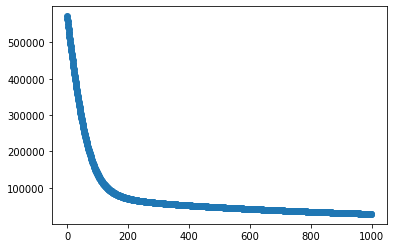

In [30]:
xrow = np.arange(0,len(traincost),1).reshape(-1,1)
plt.scatter(xrow, traincost)
plt.show()

## Ver el costo en el set de cross validation

In [31]:
cross_validation_cost = cost(yvalidate, xvalidate, train_theta_results)
cross_validation_cost

40372.60771943664

## Ver costo en el set de testing

In [32]:
testing_cost = cost(ytest, xtest, train_theta_results)
testing_cost

23050.493597596036

# Conclusiones
El modelo tiene un buen ajuste con el training y testing set. Sin embargo, el costo es más elevado en el cross validation. Esto significa que no asegura una generalización totalmente acertada, pero de igual manera hace un buen trabajo. El cost score entre los 3 no tiene una variación significativa.